## 一、验证码图片处理

In [1]:
from PIL import Image

In [2]:
# 处理像素
def regularized(img):
    width, height = img.size
    for h in range(height):
        for w in range(width):
            pixel = img.getpixel((w, h))
            if 42 <= pixel <= 43:
                pixel = 0
            else:
                pixel = 255
            img.putpixel((w, h), pixel)
    return img

In [3]:
# 切割图像
def cut(img):
    width, height = img.size
    new = img.crop((4, 1, width - 20, height - 5))
    w, h = new.size
    l = w // 4
    return [new.crop((i * l, 0, (i + 1) * l, h)) for i in range(4)]

In [4]:
# 扫描获取像素点
def scan(img):
    temp = []
    width, height = img.size
    for h in range(height):
        for w in range(width):
            pixel = img.getpixel((w, h))
            temp.append(pixel)
    return temp

## 二、卷积神经网络建模

In [5]:
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, optimizers, Sequential, utils

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
data = pd.read_csv("captcha/learn2.csv", header=None)

In [7]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,243,244,245,246,247,248,249,250,251,252
0,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,27
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,17
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,0
3,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,19
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,18


In [8]:
data.shape

(1200, 253)

In [9]:
X_train = data.iloc[:, :-1]
Y_train = data.iloc[:, -1]

In [10]:
conv = lambda x: chr(x + 48 if 0 <= x <= 9 else x + 87)

In [11]:
Y_label = Y_train.sort_values().apply(conv)

In [12]:
X_train = X_train / 255.0

In [13]:
X_train = X_train.values.reshape(-1,21,12,1)

In [14]:
Y_train = utils.to_categorical(Y_train)

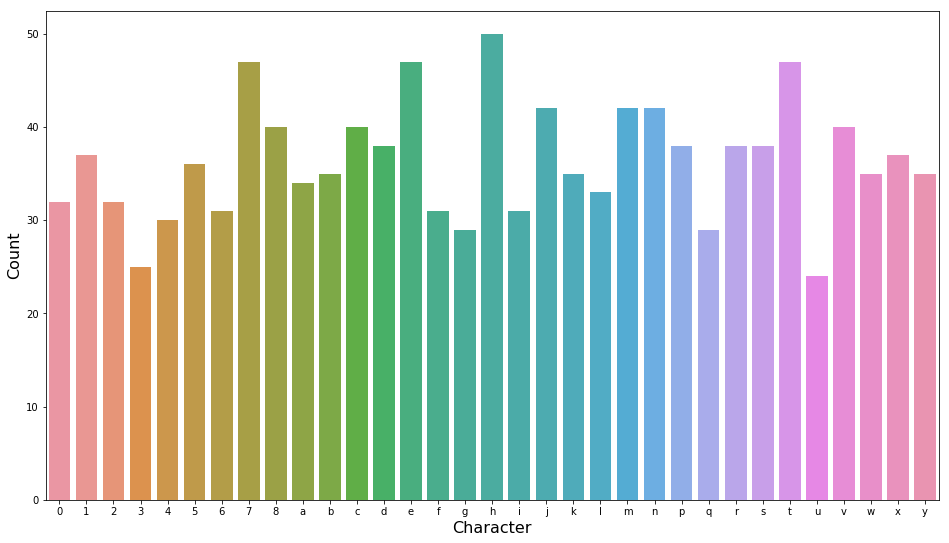

In [15]:
plt.subplots(figsize=(16,9))
sns.countplot(Y_label)
plt.xlabel('Character', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()

In [16]:
# 缺少字符9，o和z，可能与g，0和2难以区分有关

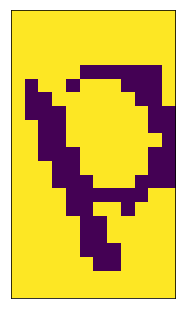

In [17]:
ax = plt.gca()
plt.imshow(X_train[9,...,0])
# plt.axis('off')
# 去白
plt.gca().xaxis.set_major_locator(plt.NullLocator()) 
plt.gca().yaxis.set_major_locator(plt.NullLocator()) 
plt.subplots_adjust(top=1,bottom=0,left=0,right=1,hspace=0,wspace=0) 
plt.show()

In [18]:
model = Sequential((
    layers.Conv2D(32, kernel_size=(5, 5), padding="same", activation='relu', input_shape=(21, 12, 1)),
    layers.Conv2D(32, kernel_size=(5, 5), padding="same", activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu'),
    layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2), strides=(2,2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(35, activation='softmax'),
))

In [19]:
optimizer = optimizers.RMSprop(lr=1e-3)

In [20]:
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])

In [26]:
epochs = 30
cap = model.fit(X_train, Y_train, epochs=epochs, batch_size=30)

Train on 1200 samples
Epoch 1/30
1200/1200 [==============================] - 1s 525us/sample - loss: 0.0063 - accuracy: 0.9992
Epoch 2/30
1200/1200 [==============================] - 0s 277us/sample - loss: 0.0089 - accuracy: 0.9958
Epoch 3/30
1200/1200 [==============================] - 0s 256us/sample - loss: 0.0022 - accuracy: 0.9983
Epoch 4/30
1200/1200 [==============================] - 0s 264us/sample - loss: 0.0039 - accuracy: 0.9983
Epoch 5/30
1200/1200 [==============================] - 0s 264us/sample - loss: 0.0124 - accuracy: 0.9975
Epoch 6/30
1200/1200 [==============================] - 0s 272us/sample - loss: 0.0012 - accuracy: 0.9992
Epoch 7/30
1200/1200 [==============================] - 0s 274us/sample - loss: 0.0103 - accuracy: 0.9975
Epoch 8/30
1200/1200 [==============================] - 0s 269us/sample - loss: 0.0102 - accuracy: 0.9992
Epoch 9/30
1200/1200 [==============================] - 0s 274us/sample - loss: 0.0270 - accuracy: 0.9942
Epoch 10/30
1200/1200 [=

In [27]:
n = pd.Series(list(map(conv, model.predict_classes(X_train))))
m = pd.Series(list(map(conv, data.iloc[:, -1])))

In [28]:
tf.where((n == m)==False)

<tf.Tensor: id=28351, shape=(0, 1), dtype=int64, numpy=array([], shape=(0, 1), dtype=int64)>

In [29]:
(n==m).all()

True

In [30]:
# 说明识别完全正确

In [35]:
# 保存模型
# model.save('model')

## 三、预测新验证码

In [36]:
from PIL import Image

In [39]:
captcha = 'captcha/unknown/0.png'
imgs = cut(regularized(Image.open(captcha)))
data = [scan(img) for img in imgs]

In [41]:
x = pd.DataFrame(data) / 255.0
x = x.values.reshape(-1,21,12,1)

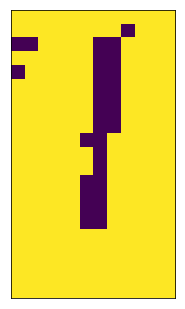

In [42]:
ax = plt.gca()
plt.imshow(x[3,...,0])
plt.gca().xaxis.set_major_locator(plt.NullLocator()) 
plt.gca().yaxis.set_major_locator(plt.NullLocator()) 
plt.subplots_adjust(top=1,bottom=0,left=0,right=1,hspace=0,wspace=0) 
plt.show()

In [45]:
# 输出预测值
list(map(conv, model.predict_classes(x)))

['d', 'e', '5', 'l']

### 批量预测

In [46]:
X = pd.read_csv("captcha/learn3.csv", header=None)
X = pd.DataFrame(X) / 255.0
X = X.values.reshape(-1,21,12,1)

In [48]:
import numpy as np

In [51]:
# 输出预测值
lst = list(map(conv, model.predict_classes(X)))

In [60]:
res = np.array(lst).reshape(-1, 4).tolist()

In [61]:
res[:5]

[['d', 'e', '5', 'l'],
 ['n', '2', 'i', 'b'],
 ['e', 'x', '1', 'x'],
 ['0', '8', '2', 's'],
 ['0', '8', '2', 's']]

In [69]:
with open("captcha/labels", "w") as fp:
    for i in res:
        fp.write(''.join(i) + '\n')